 Multigrid方法的核心思想就是不同频率的收敛速度是不同的。
 
 让我们来用实验说明不同的频率对迭代法收敛速度的影响

 本实验来自A Multigrid Tutotrial(ppt p.23)
 
 https://web.archive.org/web/20061006153457/http://www.llnl.gov/casc/people/henson/mgtut/welcome.html

 首先, 我们要求解的问题是

 $$ Au=0 $$
 
离散形式为
 $$
 -u_{i-1} + 2u_i - u_{i+1} = 0\\
 1\leq i \leq N-1
 $$

边界值为
$$
u_0 = u_{N} = 0
$$

(我们用u代表真值，v代表近似解)

 我们将Fourier modes作为初始值, 其中N=64, 即
 $$
\overrightarrow{v_k}=\left(v_i\right)_k=\sin \left(\frac{i k \pi}{N}\right)
$$
$$
1 \leq i \leq N-1, \quad
1 \leq k \leq N-1
$$
其中i代表component, k代表mode

我们绘制出k=1,3,6的图像

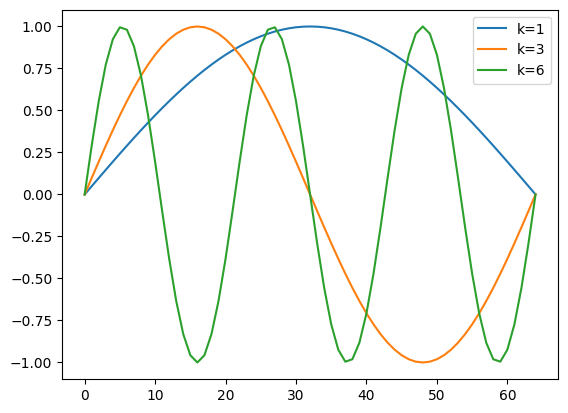

In [20]:
import matplotlib.pyplot as plt
import numpy as np

N = 64
v = np.zeros((N+1,N+1),dtype=np.float64)

for i in range(1,N):
    for k in range(1,N):
        v[i,k] = np.sin(i*k*np.pi/N)
v1 = v[:,1]
v3 = v[:,2]
v6 = v[:,6]

plt.plot(v1, label="k=1")
plt.plot(v3, label="k=3")
plt.plot(v6, label="k=6")
plt.legend()

可见k=1,3,6频率越来越高。

然后我们利用weighted Jacobi迭代法进行迭代, 其中omega=2/3

它的迭代公式为：
$$
v_i^{(new)}=(1-\omega)v_{i}^{(old)} + (\omega/ 2) \left(v_{i-1}^{(old)}+v_{i+1}^{(old)} +h^2 f_i \right)
$$


将A分解为A=D-L-U，得到矩阵形式的迭代公式为
$$
\begin{aligned}
v^{(\text {new })}= & {\left[(1-\omega) I+\omega D^{-1}(L+U)\right] v^{(\text {old })}+\omega h^2 D^{-1} f } \\
& =R_\omega v^{(\text {old })}+\omega h^2 D^{-1} f
\end{aligned}
$$

其中
$$
R_\omega=\left[(1-\omega) I+\omega D^{-1}(L+U)\right]
$$

因为$e^{new}=u^{new}-v^{new}=R(u^{old}-v^{old})=Re^{old}$，所以
$$
e^{(new)}=R_\omega e^{(old)}
$$

我们设定初始值为
$$
v_0=\frac{1}{3}\left(\sin \left(\frac{j \pi}{N}\right)+\sin \left(\frac{6 j \pi}{N}\right)+\sin \left(\frac{32 j \pi}{N}\right)\right)
$$


在我们的例子中，omega=2/3, f=0, h=1/N


我们写出来A是什么
$$
\begin{gathered}
i=1 &\quad-u_0+2 u_1-u_2=0 \\
i=2 &\quad-u_1+2 u_2-u_3=0 \\
\vdots\\
i=N-1 &\quad -u_{N-2}+2 u_{N-1}-u_N=0
\end{gathered}
$$
(注意到$u_0=u_N=0$)

$$
A=\begin{bmatrix}
 2&  -1&  &      \\
 -1 &  2&  -1&     \\
 &&   \vdots \\
 &  &  &  &  -1&  2  \\
\end{bmatrix} 
$$

A=D-L-U 其中D就是对角线，L是下三角，U是上三角。我们可以写出来
$$
D=\begin{bmatrix}
 2&  &  &        \\
 &   2 &  &       \\
 &    &      \ddots \\
 &  &    &  2 \\
\end{bmatrix}
$$

$$
L=\begin{bmatrix}
 0&  &  &  &  &    \\
 -1&   0 &  &  &  &   \\
 &    -1&    0&   &  &   \\
 &    &    &   \ddots \\
&  &  &    -1&  0 \\
\end{bmatrix}
$$

$$
U=\begin{bmatrix}
 0&  -1&  &  &  \\
 &   0 &  -1&  & \\
 &    &   \ddots\\
 &  &  &    0\\
\end{bmatrix}

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
D = np.diag(np.ones(N-1,dtype=np.float64) * 2)
L = np.diag(np.ones(N-2,dtype=np.float64) ,1)
U = np.diag(np.ones(N-2,dtype=np.float64) ,-1)
A = D - L - U
I = np.eye(N-1)
R = 1./3 * I + 1./3 * np.linalg.inv(D) @ (L + U)
R

array([[0.33333333, 0.16666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.33333333, 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.16666667, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.16666667,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.33333333,
        0.16666667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.16666667,
        0.33333333]])

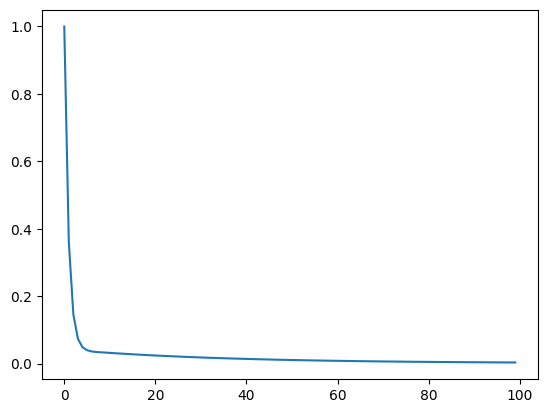

In [50]:
# 首先我们绘制v的误差下降曲线
v0 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v0[j] = 1/3 * (np.sin(j*np.pi/N) + np.sin(6*j*np.pi/N) + np.sin(32*j*np.pi/N))
v_new = np.zeros((N+1),dtype=np.float64)
v_old = np.zeros((N+1),dtype=np.float64)
num_iters = 100
v_old = v0
error = []
for i in range(num_iters):
    v_new[1:N] = 1./3 * v_old[1:N] + 1./3 * (v_old[2:N+1] + v_old[0:N-1])
    error.append(np.linalg.norm((v_new[1:N] - v_old[1:N]),np.inf) )
    v_old[:] = v_new[:]
plt.plot(error/error[0])

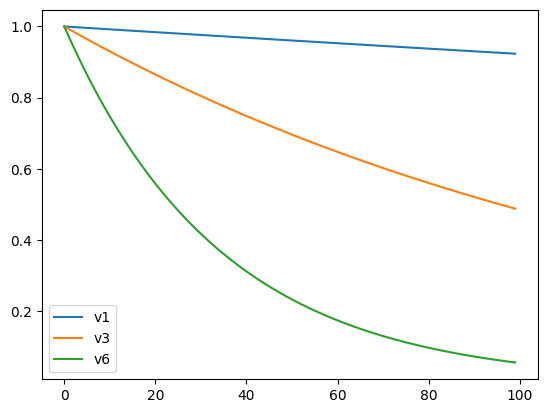

In [56]:
# 然后我们分别绘制v1,v3,v6的误差下降曲线
# 迭代公式完全一样，只有初始值不一样

def weighted_jacobian(v0, label):
    v_new = np.zeros((N+1),dtype=np.float64)
    v_old = np.zeros((N+1),dtype=np.float64)
    num_iters = 100
    v_old = v0
    error = []
    for i in range(num_iters):
        v_new[1:N] = 1./3 * v_old[1:N] + 1./3 * (v_old[2:N+1] + v_old[0:N-1])
        error.append(np.linalg.norm((v_new[1:N] - v_old[1:N]),np.inf) )
        v_old[:] = v_new[:]
    plt.plot(error/error[0], label=label)

# v1
v01 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v01[j] = 1/3 * (np.sin(j*np.pi/N))
weighted_jacobian(v01,'v1')

# v3
v03 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v03[j] = 1/3 * (np.sin(3*j*np.pi/N))
weighted_jacobian(v03,'v3')

# v6
v06 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v06[j] = 1/3 * (np.sin(6*j*np.pi/N))
weighted_jacobian(v06,'v6')

plt.legend()

可见，v1的收敛速度最慢，v3的收敛速度次之，v6的收敛速度最快。
所以，频率越高，收敛速度越快。
完毕。